## Predictioneer  
Predictive modeling for Ebola outbreaks to forecast cases, deaths, and fatality rates using geographical and epidemiological data. This repository contains predictive models, implementation scripts, and a comprehensive report detailing the methodology, results, and applications in outbreak management.

<img src="images/Illustration_1.png" style="height:300px; display:block; margin:auto;">

The project was developed as part of <a href="https://unstop.com/hackathons/predictioneer-iit-bombay-1364982">**Predictioneer**</a>, a hackathon organized by the Indian Institute of Technology (IIT) Bombay.

We will begin by preprocessing and performing exploratory data analysis (EDA) on the provided dataset, followed by building and optimizing the prediction model.

### Loading the Dataset

#### Description for the dataset
* There are rows with missing latitudes and longitudes ignore those 
* You have CFR data in all rows and deaths in a few and confirmed cases unknown 
* Deaths you have to predict the gaps and as soon as you have the data for deaths you can get the confirmed cases from CFR ratio 
*  Any exteranl factors that you might think may affect the prediction you can use like temperature or so but you have to provide a clear explaination for the same
* Case fatality ratio= (death / confirmed )* 100
* Provide a single CSV file with all the predictions

In [16]:
# Importing Required Libraries
import numpy as np
import pandas as pd

train_df = pd.read_csv("data/raw/train_data.csv")

# Printing Training Dataset
print("Training Dataset is:\n")
print(train_df)

Training Dataset is:

            Lat       Long_  Deaths  Case_Fatality_Ratio
0     33.939110   67.709953     NaN             3.779217
1     41.153300   20.168300     NaN             1.077234
2     28.033900    1.659600     NaN             2.536905
3     42.506300    1.521800   165.0             0.345543
4    -11.202700   17.873900     NaN             1.836434
...         ...         ...     ...                  ...
4011  31.952200   35.233200     NaN             0.811686
4012  39.904200  116.407400     0.0             0.000000
4013  15.552727   48.516388     NaN            18.074508
4014 -13.133897   27.849332     NaN             1.201603
4015 -19.015438   29.154857     NaN             2.168235

[4016 rows x 4 columns]


In [4]:
test_df = pd.read_csv("data/raw/test_data.csv")

# Printing Training Dataset
print("Testing Dataset is:\n")
print(test_df)

Testing Dataset is:

            Lat       Long_
0     41.153300   20.168300
1    -71.949900   23.347000
2    -35.473500  149.012400
3    -34.928500  138.600700
4     47.516200   14.550100
...         ...         ...
999   49.213800   -2.135800
1000  -7.946700  -14.355900
1001  52.130700   -3.783700
1002   6.423800  -66.589700
1003  15.552727   48.516388

[1004 rows x 2 columns]


### Seeing Columns of the dataset

In [6]:
print("Training Dataset Columns:\n")
print(train_df.columns)

print("\nTesting Dataset Columns:\n")
print(test_df.columns)

Training Dataset Columns:

Index(['Lat', 'Long_', 'Deaths', 'Case_Fatality_Ratio'], dtype='object')

Testing Dataset Columns:

Index(['Lat', 'Long_'], dtype='object')


### Seeing Descriptive Statistics

In [8]:
print("Training Dataset Columns Description:\n")
print(train_df.describe)

print("\nTesting Dataset Columns Description:\n")
print(test_df.describe)

Training Dataset Columns Description:

<bound method NDFrame.describe of             Lat       Long_  Deaths  Case_Fatality_Ratio
0     33.939110   67.709953     NaN             3.779217
1     41.153300   20.168300     NaN             1.077234
2     28.033900    1.659600     NaN             2.536905
3     42.506300    1.521800   165.0             0.345543
4    -11.202700   17.873900     NaN             1.836434
...         ...         ...     ...                  ...
4011  31.952200   35.233200     NaN             0.811686
4012  39.904200  116.407400     0.0             0.000000
4013  15.552727   48.516388     NaN            18.074508
4014 -13.133897   27.849332     NaN             1.201603
4015 -19.015438   29.154857     NaN             2.168235

[4016 rows x 4 columns]>

Testing Dataset Columns Description:

<bound method NDFrame.describe of             Lat       Long_
0     41.153300   20.168300
1    -71.949900   23.347000
2    -35.473500  149.012400
3    -34.928500  138.600700
4   

### Handling Missing Values

#### Explanation
1. **Handling Missing Latitudes and Longitudes**:
   - Rows with missing `latitude` (`Lat`) and `longitude` (`Long_`) are dropped using `dropna()` for better data integrity.

2. **Filling Missing Deaths**:
   - Missing `deaths` values are filled using **linear interpolation**. This approach estimates the missing data points based on surrounding values. You can modify this to other imputation methods like **forward fill** (`ffill`) or **mean imputation** based on your needs.

3. **Calculating Confirmed Cases**:
   - `confirmed_cases` are derived using the **Case Fatality Ratio (CFR)**, which is calculated as:
   
        **Case Fatality Ratio (CFR):**  
        CFR = (deaths / confirmed cases) × 100
        
   - Rearranged to calculate `confirmed_cases`:
   
        **Confirmed Cases** = (deaths / CFR) × 100

#### Code Workflow
- **Latitude and Longitude Handling**: The `fill_missing_lat_lon` function drops rows with missing latitude and longitude values.
- **Deaths and Confirmed Cases Handling**: The `fill_missing_deaths_and_cases` function interpolates missing death counts and calculates the confirmed cases based on the Case Fatality Ratio.
- The results are processed for both the `train_df` and `test_df` datasets and saved to a single CSV file named `predictions.csv`.

This method ensures that the dataset remains consistent and reliable for analysis and predictions.

In [18]:
# Display all columns for better visibility
pd.set_option('display.max_columns', None)

# Fill missing latitude and longitude
def fill_missing_lat_lon(df):
    """Drops rows with missing latitudes and longitudes."""
    df = df.dropna(subset=['Lat', 'Long_'])
    return df

# Fill missing deaths and calculate confirmed cases using Case Fatality Ratio (CFR)
def fill_missing_deaths_and_cases(df):
    """Fills missing deaths using interpolation and calculates confirmed cases."""
    # Interpolate missing deaths (linear interpolation)
    if 'Deaths' in df.columns:
        df['Deaths'] = df['Deaths'].interpolate(method='linear', limit_direction='both')

    # Calculate confirmed cases from Case Fatality Ratio
    if 'Case_Fatality_Ratio' in df.columns:
        df['Confirmed_Cases'] = df.apply(
            lambda row: (row['Deaths'] / row['Case_Fatality_Ratio'] * 100)
            if not pd.isnull(row['Case_Fatality_Ratio']) and row['Case_Fatality_Ratio'] != 0
            else np.nan,
            axis=1
        )
    return df

In [20]:
# Main Workflow
print("Preprocessing for train_df:")
train_df = fill_missing_lat_lon(train_df)
train_df = fill_missing_deaths_and_cases(train_df)

print("Preprocessing for test_df:")
test_df = fill_missing_lat_lon(test_df)

# Save results to a CSV file

train_df.to_csv('data/interim/train_data.csv', index=False)

test_df.to_csv('data/interim/test_data.csv', index=False)

print("Preprocessed CSV files saved to directory")


Preprocessing for train_df:
Preprocessing for test_df:
Preprocessed CSV files saved to directory


### Exploratory Data Analysis

EDA for Training Dataset:
Training Data Information:
<class 'pandas.core.frame.DataFrame'>
Index: 3925 entries, 0 to 4015
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Lat                  3925 non-null   float64
 1   Long_                3925 non-null   float64
 2   Deaths               3925 non-null   float64
 3   Case_Fatality_Ratio  3922 non-null   float64
 4   Confirmed_Cases      3808 non-null   float64
dtypes: float64(5)
memory usage: 184.0 KB
None

Missing Values in Training Data:
Lat                      0
Long_                    0
Deaths                   0
Case_Fatality_Ratio      3
Confirmed_Cases        117
dtype: int64

Descriptive Statistics for Numerical Columns in Training Data:
               Lat        Long_       Deaths  Case_Fatality_Ratio  \
count  3925.000000  3925.000000  3925.000000          3922.000000   
mean     35.736183   -71.109728    78.165223             1.589198

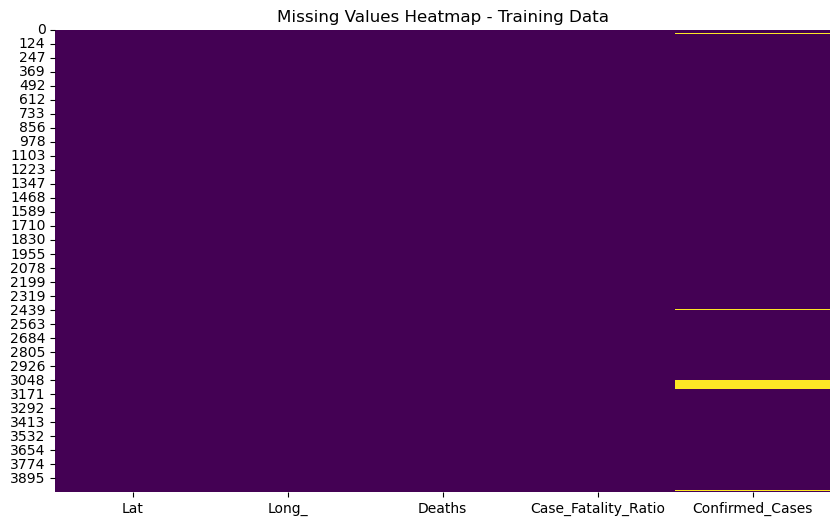

In [ ]:
# Importing Required Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Display all columns for better visibility
pd.set_option('display.max_columns', None)

# EDA for the Training Dataset
def eda_train_df(df):
    """Performs EDA on the training dataset."""
    
    # Display basic information and missing values
    print("Training Data Information:")
    print(df.info())
    print("\nMissing Values in Training Data:")
    print(df.isnull().sum())
    
    # Descriptive statistics for numerical columns
    print("\nDescriptive Statistics for Numerical Columns in Training Data:")
    print(df.describe())

    # Visualizing missing values (heatmap)
    plt.figure(figsize=(10, 6))
    sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
    plt.title("Missing Values Heatmap - Training Data")
    plt.show()

    # Pairplot to visualize correlations and distributions of numeric data
    sns.pairplot(df)
    plt.suptitle("Pairplot - Training Data", y=1.02)
    plt.show()

# EDA for the Testing Dataset
def eda_test_df(df):
    """Performs EDA on the testing dataset."""
    
    # Display basic information and missing values
    print("Testing Data Information:")
    print(df.info())
    print("\nMissing Values in Testing Data:")
    print(df.isnull().sum())
    
    # Visualizing missing values (heatmap)
    plt.figure(figsize=(10, 6))
    sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
    plt.title("Missing Values Heatmap - Testing Data")
    plt.show()

# Perform EDA on both datasets
print("EDA for Training Dataset:")
eda_train_df(train_df)

print("\nEDA for Testing Dataset:")
eda_test_df(test_df)
